# TMY to Power Tutorial

This tutorial will walk through the process of going from TMY data to AC power using the SAPM.

Table of contents:
1. [Setup](#Setup)
2. [Load TMY data](#Load-TMY-data)
2. [Calculate modeling intermediates](#Calculate-modeling-intermediates)
2. [Calculate DC power using SAPM](#Calculate-DC-power-using-SAPM)
2. [Calculate AC power using SAPM](#Calculate-AC-power-using-SAPM)

This tutorial has been tested against the following package versions:
* pvlib 0.2.0
* Python 2.7.10
* IPython 3.2
* pandas 0.16.2

It should work with other Python and Pandas versions. It requires pvlib >= 0.2.0 and IPython >= 3.0.

Authors:
* Will Holmgren (@wholmgren), University of Arizona, July 2015
* Rob Andrews (@Calama-Consulting), Heliolytics, June 2014

## Setup

These are just your standard interactive scientific python imports that you'll get very used to using.

In [1]:
# built-in python modules
import os
import inspect

# scientific python add-ons
import numpy as np
import pandas as pd

# plotting stuff
# first line makes the plots appear in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt
# seaborn makes your plots look better
try:
    import seaborn as sns
    sns.set(rc={"figure.figsize": (12, 6)})
except ImportError:
    print('We suggest you install seaborn using conda or pip and rerun this cell')

# finally, we import the pvlib library
import pvlib

## Load TMY data

pvlib comes with a couple of TMY files, and we'll use one of them for simplicity. You could also load a file from disk, or specify a url. See this NREL website for a list of TMY files:

http://rredc.nrel.gov/solar/old_data/nsrdb/1991-2005/tmy3/by_state_and_city.html

In [2]:
# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# absolute path to a data file
datapath = os.path.join(pvlib_abspath, 'data', '703165TY.csv')

# read tmy data with year values coerced to a single year
tmy_data, meta = pvlib.tmy.readtmy3(datapath, coerce_year=2015)
tmy_data.index.name = 'Time'

# TMY data seems to be given as hourly data with time stamp at the end
# shift the index 30 Minutes back for calculation of sun positions
tmy_data = tmy_data.shift(freq='-30Min')

The file handling above looks complicated because we're trying to account for the many different ways that people will run this notebook on their systems. You can just put a simple string path into the ``readtmy3`` function if you know where the file is.

Let's look at the imported version of the TMY file.

In [3]:
tmy_data.head()

,ETR,ETRN,GHI,GHISource,GHIUncertainty,DNI,DNISource,DNIUncertainty,DHI,DHISource,...,AOD,AODSource,AODUncertainty,Alb,AlbSource,AlbUncertainty,Lprecipdepth,Lprecipquantity,LprecipSource,LprecipUncertainty
Time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:30:00-09:00,0,0,0,1,0,0,1,0,0,1,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0
2015-01-01 01:30:00-09:00,0,0,0,1,0,0,1,0,0,1,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0
2015-01-01 02:30:00-09:00,0,0,0,1,0,0,1,0,0,1,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0
2015-01-01 03:30:00-09:00,0,0,0,1,0,0,1,0,0,1,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0
2015-01-01 04:30:00-09:00,0,0,0,1,0,0,1,0,0,1,...,0.051,F,8,0.24,F,8,-9900,-9900,?,0


This is a ``pandas DataFrame`` object. It has a lot of great properties that are beyond the scope of our tutorials.

Plot the GHI data from the TMY file

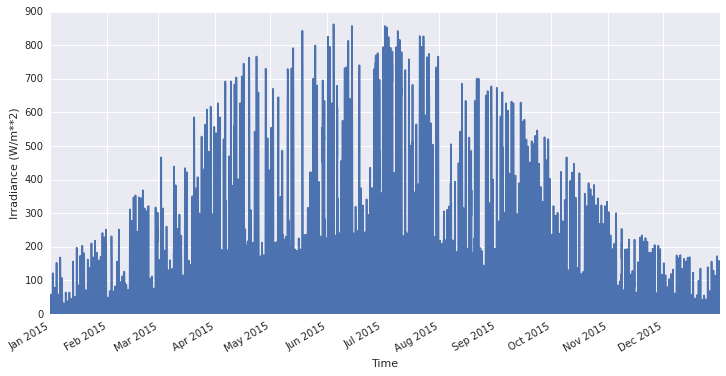

In [4]:
tmy_data['GHI'].plot()
plt.ylabel('Irradiance (W/m**2)')

## Calculate modeling intermediates

Before we can calculate power for all times in the TMY file, we will need to calculate:
* solar position 
* extra terrestrial radiation
* airmass
* angle of incidence
* POA sky and ground diffuse radiation
* cell and module temperatures

First, define some PV system parameters.

In [5]:
surface_tilt = 30
surface_azimuth = 180 # pvlib uses 0=North, 90=East, 180=South, 270=West convention
albedo = 0.2

# create pvlib Location object based on meta data
sand_point = pvlib.location.Location(meta['latitude'], meta['longitude'], tz='US/Alaska', 
                                     altitude=meta['altitude'], name=meta['Name'].replace('"',''))
print(sand_point)

SAND POINT: latitude=55.317, longitude=-160.517, tz=US/Alaska, altitude=7.0


### Solar position

Calculate the solar position for all times in the TMY file. 

The default solar position algorithm is based on Reda and Andreas (2004). Our implementation is pretty fast, but you can make it even faster if you install [``numba``](http://numba.pydata.org/#installing) and use add  ``method='nrel_numba'`` to the function call below.

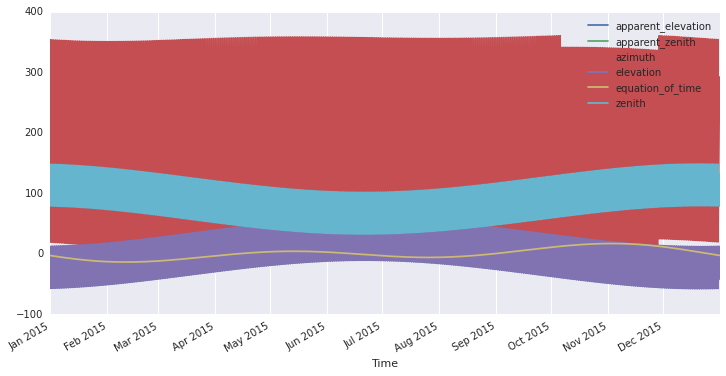

In [6]:
solpos = pvlib.solarposition.get_solarposition(tmy_data.index, sand_point)

solpos.plot()

The funny looking jump in the azimuth is just due to the coarse time sampling in the TMY file.

### DNI ET

Calculate extra terrestrial radiation. This is needed for many plane of array diffuse irradiance models.

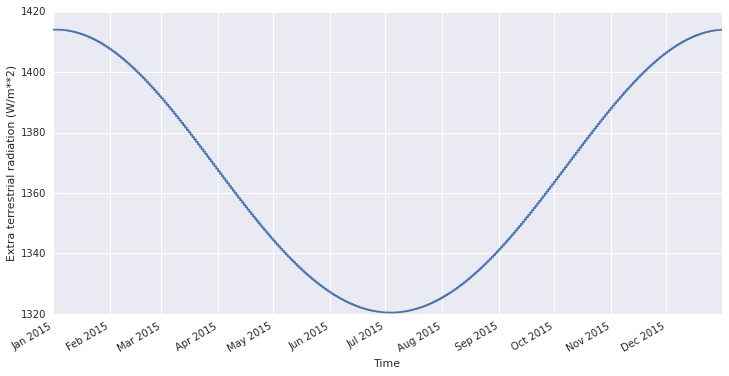

In [7]:
# the extraradiation function returns a simple numpy array
# instead of a nice pandas series. We will change this
# in a future version
dni_extra = pvlib.irradiance.extraradiation(tmy_data.index)
dni_extra = pd.Series(dni_extra, index=tmy_data.index)

dni_extra.plot()
plt.ylabel('Extra terrestrial radiation (W/m**2)')

### Airmass

Calculate airmass. Lots of model options here, see the ``atmosphere`` module tutorial for more details.

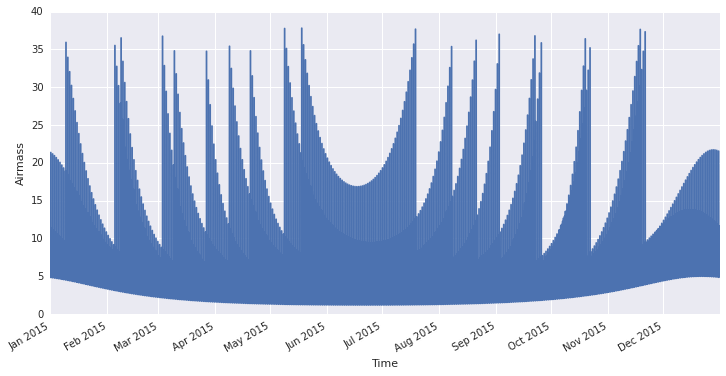

In [8]:
airmass = pvlib.atmosphere.relativeairmass(solpos['apparent_zenith'])

airmass.plot()
plt.ylabel('Airmass')

The funny appearance is due to aliasing and setting invalid numbers equal to ``NaN``. Replot just a day or two and you'll see that the numbers are right.

### POA sky diffuse

Use the Hay Davies model to calculate the plane of array diffuse sky radiation. See the ``irradiance`` module tutorial for comparisons of different models.

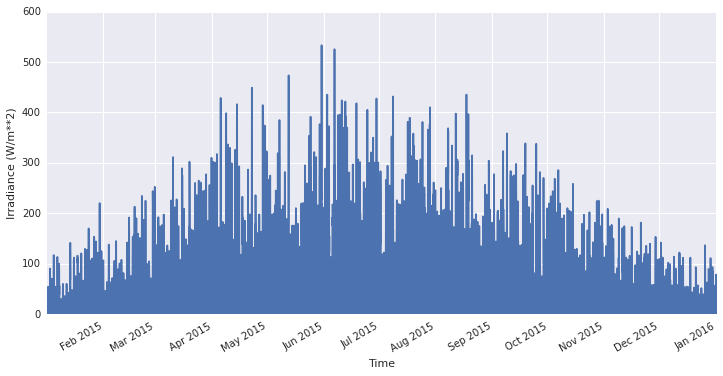

In [9]:
poa_sky_diffuse = pvlib.irradiance.haydavies(surface_tilt, surface_azimuth,
                                             tmy_data['DHI'], tmy_data['DNI'], dni_extra,
                                             solpos['apparent_zenith'], solpos['azimuth'])

poa_sky_diffuse.plot()
plt.ylabel('Irradiance (W/m**2)')

### POA ground diffuse

Calculate ground diffuse. We specified the albedo above. You could have also provided a string to the ``surface_type`` keyword argument.

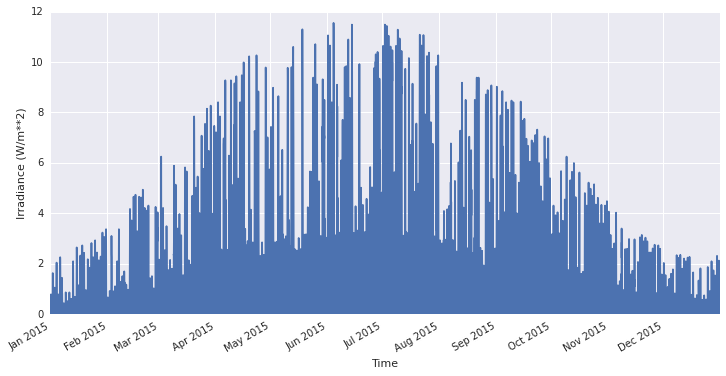

In [10]:
poa_ground_diffuse = pvlib.irradiance.grounddiffuse(surface_tilt, tmy_data['GHI'], albedo=albedo)

poa_ground_diffuse.plot()
plt.ylabel('Irradiance (W/m**2)')

### AOI

Calculate AOI

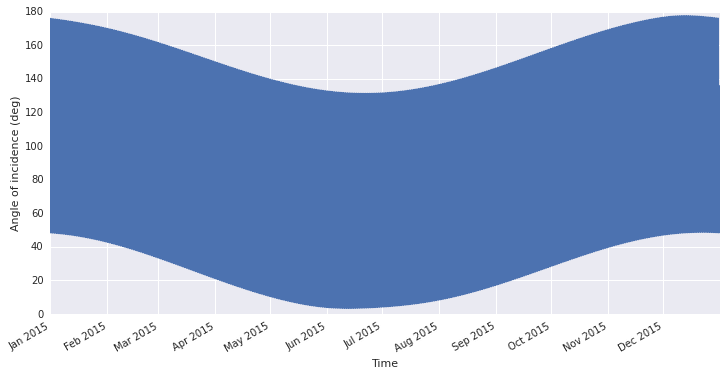

In [11]:
aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth, solpos['apparent_zenith'], solpos['azimuth'])

aoi.plot()
plt.ylabel('Angle of incidence (deg)')

Note that AOI has values greater than 90 deg. This is ok.

### POA total

Calculate POA irradiance

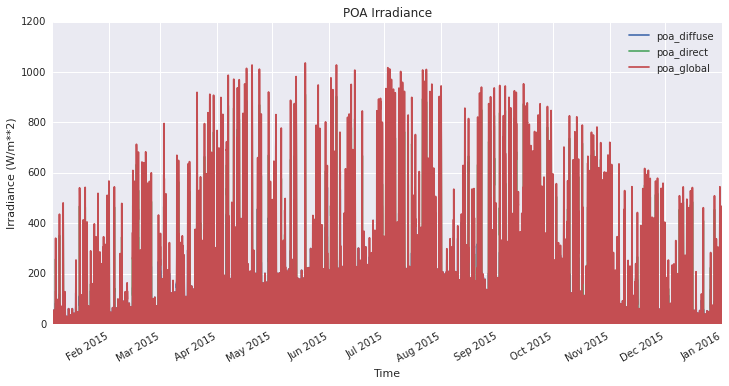

In [12]:
poa_irrad = pvlib.irradiance.globalinplane(aoi, tmy_data['DNI'], poa_sky_diffuse, poa_ground_diffuse)

poa_irrad.plot()
plt.ylabel('Irradiance (W/m**2)')
plt.title('POA Irradiance')

### Cell and module temperature

Calculate pv cell and module temperature

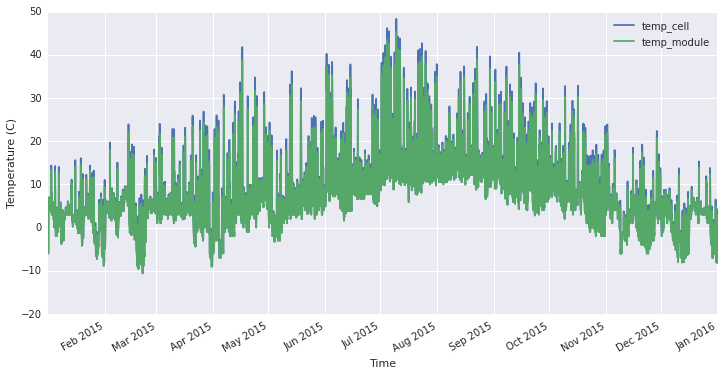

In [13]:
pvtemps = pvlib.pvsystem.sapm_celltemp(poa_irrad['poa_global'], tmy_data['Wspd'], tmy_data['DryBulb'])

pvtemps.plot()
plt.ylabel('Temperature (C)')

## DC Power using SAPM

Get module data from the web.

In [14]:
sandia_modules = pvlib.pvsystem.retrieve_sam(name='SandiaMod')

Choose a particular module

In [15]:
sandia_module = sandia_modules.Canadian_Solar_CS5P_220M___2009_
sandia_module

Vintage                                                   2009
Area                                                     1.701
Material                                                  c-Si
#Series                                                     96
#Parallel                                                    1
Isco                                                   5.09115
Voco                                                   59.2608
Impo                                                   4.54629
Vmpo                                                   48.3156
Aisc                                                  0.000397
Aimp                                                  0.000181
C0                                                     1.01284
C1                                                  -0.0128398
Bvoco                                                 -0.21696
Mbvoc                                                        0
Bvmpo                                                -0

Run the SAPM using the parameters we calculated above.

                           i_sc  i_mp  v_oc  v_mp  p_mp  i_x  i_xx  \
Time                                                                 
2015-01-01 09:30:00+00:00     0     0     0     0     0    0     0   
2015-01-01 10:30:00+00:00     0     0     0     0     0    0     0   
2015-01-01 11:30:00+00:00     0     0     0     0     0    0     0   
2015-01-01 12:30:00+00:00     0     0     0     0     0    0     0   
2015-01-01 13:30:00+00:00     0     0     0     0     0    0     0   

                           effective_irradiance  
Time                                             
2015-01-01 09:30:00+00:00                     0  
2015-01-01 10:30:00+00:00                     0  
2015-01-01 11:30:00+00:00                     0  
2015-01-01 12:30:00+00:00                     0  
2015-01-01 13:30:00+00:00                     0  


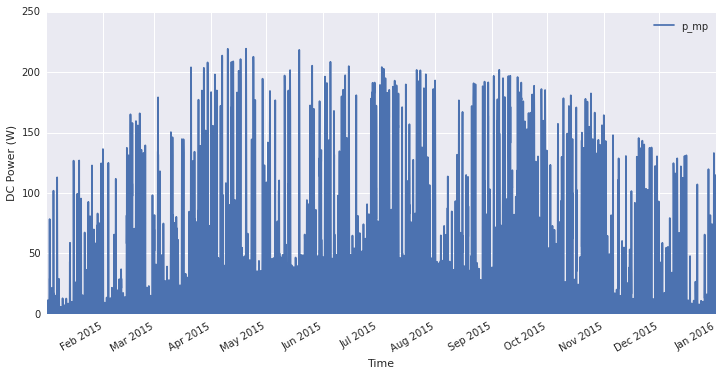

In [16]:
sapm_out = pvlib.pvsystem.sapm(sandia_module, poa_irrad.poa_direct, poa_irrad.poa_diffuse,
                              pvtemps['temp_cell'], airmass, aoi)
print(sapm_out.head())

sapm_out[['p_mp']].plot()
plt.ylabel('DC Power (W)')

## AC Power using SAPM

Get the inverter database from the web

In [17]:
sapm_inverters = pvlib.pvsystem.retrieve_sam('sandiainverter')

Choose a particular inverter

In [18]:
sapm_inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_']
sapm_inverter

Vac          208.000000
Paco         250.000000
Pdco         259.522000
Vdco          40.242600
Pso            1.771610
C0            -0.000025
C1            -0.000090
C2             0.000669
C3            -0.018881
Pnt            0.020000
Vdcmax        65.000000
Idcmax        10.000000
Mppt_low      20.000000
Mppt_high     50.000000
Name: ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_, dtype: float64

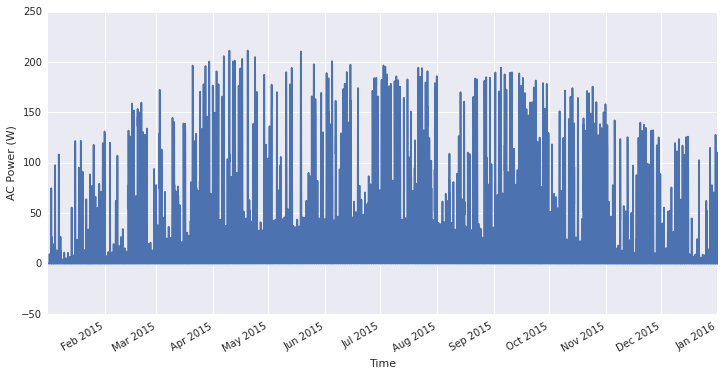

In [19]:
p_ac = pvlib.pvsystem.snlinverter(sapm_inverter, sapm_out.v_mp, sapm_out.p_mp)

p_ac.plot()
plt.ylabel('AC Power (W)')

See the ``pvsystem`` module tutorial for an example using the single diode model.

Some statistics on the AC power

In [20]:
p_ac.describe()

count    8760.000000
mean       23.110094
std        42.359998
min        -0.020000
25%        -0.020000
50%        -0.020000
75%        27.994055
max       211.294568
dtype: float64

In [21]:
p_ac.sum()

202444.41946886043